In [60]:
import matplotlib.cm
import matplotlib.pyplot as plt
import cv2 as cv

def visualize(img, row):
    edges = [(0, 2), (1, 2), (3, 4), (4, 5), (4, 8), (5, 6), (6, 7), (8, 9), (9, 10), 
            (4, 11), (11, 12), (11, 14), (11, 16), (12, 13), (14, 15)]
    cmap = matplotlib.cm.get_cmap('Spectral')
    colors = [[255 * color for color in cmap(i / len(edges))] for i in range(len(edges))]
    width = 2
    for color, edge in zip(colors, edges):
        start_idx, end_idx = edge
        start = row[start_idx * 2], row[start_idx * 2 + 1]
        end = row[end_idx * 2], row[end_idx * 2 + 1]
        img = cv.line(img, start, end, color, width)
    plt.imshow(img)
    plt.imshow()

In [61]:
import pandas as pd
import json

In [ ]:
from tqdm import tqdm

li = []

num = 22306

for i in tqdm(range(num)):
    filename = f"26-predictions/test_cropped_{str(i).rjust(7, '0')}DLC_resnet50_baselineMar19shuffle1_350000.h5"
    filename2 = f"26-predictions/test_cropped_{str(i).rjust(7, '0')}DLC_resnet50_baselineMar19shuffle1_395000.h5"
    try:
        df = pd.read_hdf(filename)
    except:
        df = pd.read_hdf(filename2)
    li.append(df.droplevel(level=0, axis=1))

In [ ]:
df = pd.concat(li, axis=0, ignore_index=True)
df

In [ ]:
def process_row(row):
    lis = []
    for i in range(len(row)):
        if (i + 1) % 3 == 0:
            continue
        lis.append(row[i])
    return lis

In [ ]:
import json
with open("../../data/test_prediction.json") as f:
    js = json.load(f)

In [ ]:
for i in tqdm(range(22306)):
    row = df.iloc[i, :]
    processed = process_row(row)
    bbox = js['data'][i]['bbox']
    x, y, w, h = bbox
    landmarks = []
    for j in range(17 * 2):
        curr = processed[j]
        if j % 2 == 0:
            new = int(curr + x)
            landmarks.append(new)
        else:
            new = int(curr + y)
            landmarks.append(new)
    js['data'][i]['landmarks'] = landmarks

In [ ]:
js

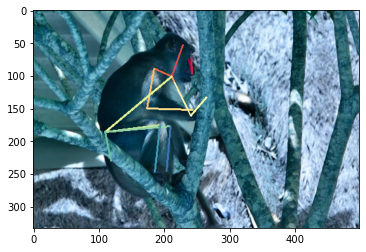

In [82]:
import cv2 as cv

idx = 449

filename = f"../../data/test/{js['data'][idx]['file']}"
img = cv.imread(filename)
visualize(img, js['data'][idx]['landmarks'])
plt.show()

In [ ]:
with open("./output/test_prediction.json", "w") as f:
    json.dump(js, f)

In [ ]:
import matplotlib.pyplot as plt
species = [j['species'] for j in js['data']]
species

In [73]:
import numpy as np
np.unique(species, return_counts=True)

(array(['Barbary_macaque', 'Bonobo', 'Chacma_baboon', 'Chimpanzee',
        'Common_marmoset', 'Cotton-top_tamarin', 'Crab-eating_macaque',
        'Dusky_leaf_monkey', 'Emperor_tamarin', 'Formosan_rock_macaque',
        'Gibbon', 'Golden_lion_tamarin', 'Golden_snub-nosed_monkey',
        'Gorilla', 'Hamadryas_baboon', 'Japanese_macaque',
        'Lion-tailed_macaque', 'Mandrill', 'Olive_baboon', 'Orangutan',
        'Proboscis_monkey', 'Rhesus_macaque', 'Siamang', 'Squirrel_monkey',
        'Tufted_capuchin', 'Vervet_monkey'], dtype='<U24'),
 array([ 533,  241,  502, 1456,  253,  347,  934,   18,  236,   62,  373,
         366,   25,  484,  504, 9921,  408,  335,  324,  479,  362, 3111,
         350,   85,   10,  587]))

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 10))
g = sns.histplot(species)
g.set(xticklabels=[])

In [83]:
data = js['data']
data_filt = list(filter(lambda x : x['species'] == "Crab-eating_macaque", data))
len(data_filt)

934

In [ ]:
import json
with open("../../data/train_annotation.json") as f:
    train = json.load(f)
# ! ls ../../data/train_annotation.json
train

[[Text(0, 0, ''),
  Text(1, 0, ''),
  Text(2, 0, ''),
  Text(3, 0, ''),
  Text(4, 0, ''),
  Text(5, 0, ''),
  Text(6, 0, ''),
  Text(7, 0, ''),
  Text(8, 0, ''),
  Text(9, 0, ''),
  Text(10, 0, ''),
  Text(11, 0, ''),
  Text(12, 0, ''),
  Text(13, 0, ''),
  Text(14, 0, ''),
  Text(15, 0, ''),
  Text(16, 0, ''),
  Text(17, 0, ''),
  Text(18, 0, ''),
  Text(19, 0, ''),
  Text(20, 0, ''),
  Text(21, 0, ''),
  Text(22, 0, ''),
  Text(23, 0, ''),
  Text(24, 0, ''),
  Text(25, 0, '')]]

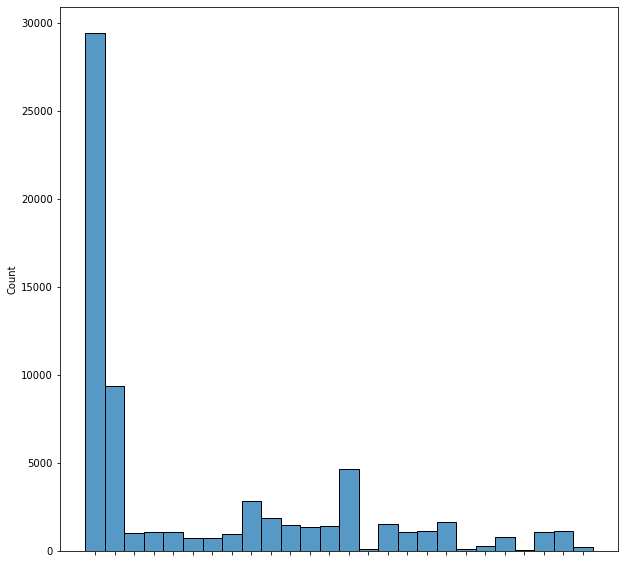

In [87]:
species = [d['species'] for d in train['data']]
plt.figure(figsize=(10, 10))
g = sns.histplot(species)
g.set(xticklabels=[])

In [90]:
filtered = list(filter(lambda x : x == "Crab-eating_macaque", species))
len(filtered)

2807

In [57]:
import numpy as np
def get_row(obj):
    landmarks = obj['landmarks']
    bbox = obj['bbox']
    x, y, w, h = bbox
    
#     extract hip landmark
    hip = landmarks[11 * 2: 11 * 2 + 2]
    x_hip, y_hip = hip
    
#     get x and y coordinates of each landmark
    xs = np.array([landmarks[i] for i in range(0, 17 * 2, 2)])
    ys = np.array([landmarks[i] for i in range(1, 17 * 2, 2)])
    
#     use hip as origin of landmarks
    xs -= x_hip
    ys -= y_hip
    
#     scale relative landmarks with bbox
    xs = xs / w
    ys = ys / h
    
#     rotate points such that the head is at 0 degrees
    head_x, head_y = xs[3], ys[3]
    theta = -1 * np.arctan2(head_y, head_x)
    rot_mat = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    xy_mat = np.stack([xs, ys])
    rotated = rot_mat @ xy_mat
    return rotated.flatten()

In [59]:
landmarks = np.array([get_row(t) for t in train['data']])
landmarks

array([[ 0.82074337,  0.77473156,  0.76168023, ...,  0.28693442,
        -0.14136623, -0.07773642],
       [ 0.62155982,  0.58045974,  0.52764401, ..., -0.11781619,
        -0.34110615, -0.0849187 ],
       [ 0.55397467,  0.53057418,  0.52949077, ..., -0.21583586,
        -0.30117458, -0.16321031],
       ...,
       [ 0.39936381,  0.41388537,  0.38887136, ...,  0.22683021,
         0.40583462,  0.03771286],
       [ 0.36078866,  0.35142899,  0.32834062, ..., -0.12331311,
        -0.09076713, -0.03109949],
       [ 0.33391519,  0.2953035 ,  0.33441644, ...,  0.25751297,
         0.3697197 ,  0.24561135]])

In [60]:
landmarks.shape

(66917, 34)

In [61]:
from sklearn.manifold import TSNE

landmarks_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random').fit_transform(landmarks)

In [62]:
species = np.unique([t['species']for t in train['data']])
species

array(['Barbary_macaque', 'Bonobo', 'Chacma_baboon', 'Chimpanzee',
       'Common_marmoset', 'Cotton-top_tamarin', 'Crab-eating_macaque',
       'Dusky_leaf_monkey', 'Emperor_tamarin', 'Formosan_rock_macaque',
       'Gibbon', 'Golden_lion_tamarin', 'Golden_snub-nosed_monkey',
       'Gorilla', 'Hamadryas_baboon', 'Japanese_macaque',
       'Lion-tailed_macaque', 'Mandrill', 'Olive_baboon', 'Orangutan',
       'Proboscis_monkey', 'Rhesus_macaque', 'Siamang', 'Squirrel_monkey',
       'Tufted_capuchin', 'Vervet_monkey'], dtype='<U24')

In [63]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(species)))
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.278791, 0.062145, 0.386592, 1.      ],
       [0.283197, 0.11568 , 0.436115, 1.      ],
       [0.280255, 0.165693, 0.476498, 1.      ],
       [0.270595, 0.214069, 0.507052, 1.      ],
       [0.253935, 0.265254, 0.529983, 1.      ],
       [0.235526, 0.309527, 0.542944, 1.      ],
       [0.21621 , 0.351535, 0.550627, 1.      ],
       [0.197636, 0.391528, 0.554969, 1.      ],
       [0.179019, 0.433756, 0.55743 , 1.      ],
       [0.163625, 0.471133, 0.558148, 1.      ],
       [0.149039, 0.508051, 0.55725 , 1.      ],
       [0.135066, 0.544853, 0.554029, 1.      ],
       [0.122606, 0.585371, 0.546557, 1.      ],
       [0.120081, 0.622161, 0.534946, 1.      ],
       [0.134692, 0.658636, 0.517649, 1.      ],
       [0.170948, 0.694384, 0.493803, 1.      ],
       [0.232815, 0.732247, 0.459277, 1.      ],
       [0.304148, 0.764704, 0.419943, 1.      ],
       [0.386433, 0.794644, 0.372886, 1.      ],
       [0.477504, 0.

In [119]:
species

array(['Barbary_macaque', 'Bonobo', 'Chacma_baboon', 'Chimpanzee',
       'Common_marmoset', 'Cotton-top_tamarin', 'Crab-eating_macaque',
       'Dusky_leaf_monkey', 'Emperor_tamarin', 'Formosan_rock_macaque',
       'Gibbon', 'Golden_lion_tamarin', 'Golden_snub-nosed_monkey',
       'Gorilla', 'Hamadryas_baboon', 'Japanese_macaque',
       'Lion-tailed_macaque', 'Mandrill', 'Olive_baboon', 'Orangutan',
       'Proboscis_monkey', 'Rhesus_macaque', 'Siamang', 'Squirrel_monkey',
       'Tufted_capuchin', 'Vervet_monkey'], dtype='<U24')

In [64]:
species_to_colors = dict([(s, c) for s, c in zip(species, colors)])
species_to_colors

{'Barbary_macaque': array([0.267004, 0.004874, 0.329415, 1.      ]),
 'Bonobo': array([0.278791, 0.062145, 0.386592, 1.      ]),
 'Chacma_baboon': array([0.283197, 0.11568 , 0.436115, 1.      ]),
 'Chimpanzee': array([0.280255, 0.165693, 0.476498, 1.      ]),
 'Common_marmoset': array([0.270595, 0.214069, 0.507052, 1.      ]),
 'Cotton-top_tamarin': array([0.253935, 0.265254, 0.529983, 1.      ]),
 'Crab-eating_macaque': array([0.235526, 0.309527, 0.542944, 1.      ]),
 'Dusky_leaf_monkey': array([0.21621 , 0.351535, 0.550627, 1.      ]),
 'Emperor_tamarin': array([0.197636, 0.391528, 0.554969, 1.      ]),
 'Formosan_rock_macaque': array([0.179019, 0.433756, 0.55743 , 1.      ]),
 'Gibbon': array([0.163625, 0.471133, 0.558148, 1.      ]),
 'Golden_lion_tamarin': array([0.149039, 0.508051, 0.55725 , 1.      ]),
 'Golden_snub-nosed_monkey': array([0.135066, 0.544853, 0.554029, 1.      ]),
 'Gorilla': array([0.122606, 0.585371, 0.546557, 1.      ]),
 'Hamadryas_baboon': array([0.120081, 0

In [ ]:
c = [species_to_colors[t['species']] for t in train['data']]
c

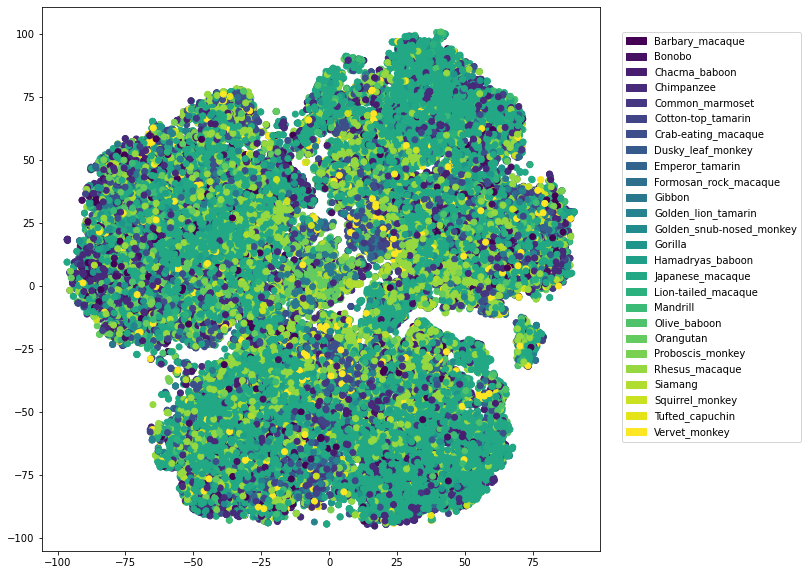

In [80]:
plt.figure(figsize=(10, 10))
plt.scatter(landmarks_embedded[:, 0], landmarks_embedded[:, 1], c=c)


import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

handles = []
for s in species:
    color = species_to_colors[s]
    pat = mpatches.Patch(color=color, label=s)
    handles.append(pat)
    
plt.legend(handles=handles, loc=(1.04,0.2))


In [83]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42).fit(landmarks_embedded)

In [86]:
kmeans.labels_

array([2, 2, 2, ..., 0, 0, 0], dtype=int32)

In [92]:
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, 3))
colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

In [ ]:
c = [colors[kmeans.labels_[i]] for i in range(66917)]
c

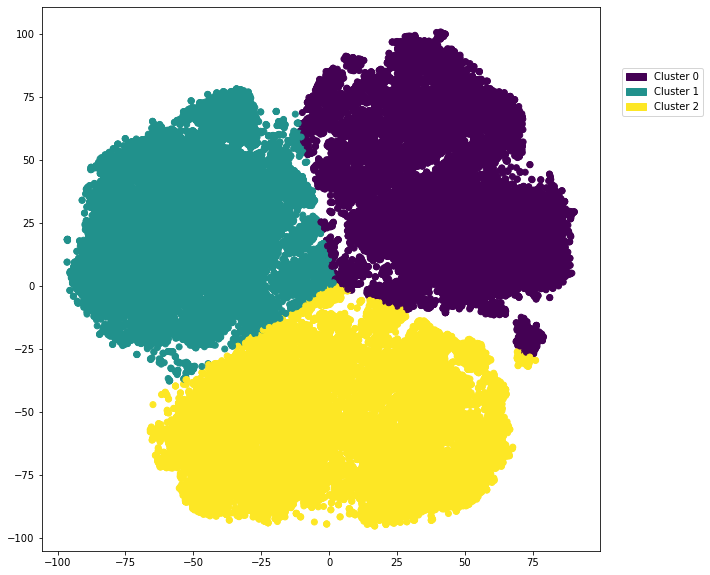

In [100]:
plt.figure(figsize=(10, 10))
plt.scatter(landmarks_embedded[:, 0], landmarks_embedded[:, 1], c=c)

handles = []
for i in range(3):
    color = colors[i]
    pat = mpatches.Patch(color=color, label=f"Cluster {i}")
    handles.append(pat)
    
plt.legend(handles=handles, loc=(1.04,0.8))

In [107]:
from scipy.stats import mode

clusters = []

for s in species:
    idxs = []
    for i in range(66917):
        if train['data'][i]['species'] == s:
            idxs.append(i)
    idxs = np.array(idxs)
    clust_assign = kmeans.labels_[idxs]
    clust = mode(clust_assign, axis=None)[0]
    clusters.append(int(clust))

In [108]:
clusters

[1, 1, 2, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 1, 1, 2, 1, 0, 2, 2]

In [116]:
c2 = [colors[clusters[i]] for i in range(26)]
c2

[array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 array([0.267004, 0.004874, 0.329415, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),
 array([0.993248, 0.906157, 0.143936, 1.      ]),
 array([0.127568, 0.566949, 0.550556, 1.      ]),


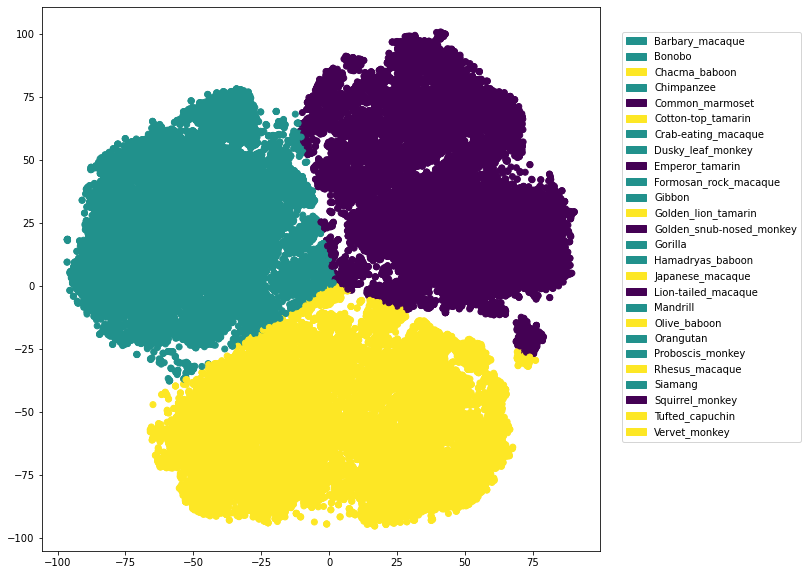

In [118]:
plt.figure(figsize=(10, 10))
plt.scatter(landmarks_embedded[:, 0], landmarks_embedded[:, 1], c=c)

handles = []
for i in range(26):
    s = species[i]
    pat = mpatches.Patch(color=c2[i], label=f"{s}")
    handles.append(pat)
    
plt.legend(handles=handles, loc=(1.04,0.2))
